### Basic library imports

In [20]:
import os
import pandas as pd

### Read Dataset

In [21]:
DATASET_FOLDER = '../dataset/'
train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))
#sample_test = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test.csv'))
#sample_test_out = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test_out.csv'))

### Run Sanity check using src/sanity.py

In [3]:
!python sanity.py --test_filename ../dataset/sample_test.csv --output_filename ../dataset/sample_test_out.csv

/bin/bash: line 1: python: command not found


In [4]:
!python sanity.py --test_filename ../dataset/sample_test.csv --output_filename ../dataset/sample_test_out_fail.csv

/bin/bash: line 1: python: command not found


### Download images

In [1]:
'''from utils import download_images
download_images(sample_test['image_link'], '../images')'''

"from utils import download_images\ndownload_images(sample_test['image_link'], '../images')"

In [3]:
assert len(os.listdir('../images')) > 0

In [7]:
rm -rf ../images

## Mapping url to its file name

In [22]:
from urllib.parse import urlparse
train['image_filename'] = train['image_link'].apply(lambda x: os.path.basename(urlparse(x).path))

# Display the dataframe to check the extracted filenames
print(train[['image_link', 'image_filename']].head())

                                          image_link   image_filename
0  https://m.media-amazon.com/images/I/61I9XdN6OF...  61I9XdN6OFL.jpg
1  https://m.media-amazon.com/images/I/71gSRbyXmo...  71gSRbyXmoL.jpg
2  https://m.media-amazon.com/images/I/61BZ4zrjZX...  61BZ4zrjZXL.jpg
3  https://m.media-amazon.com/images/I/612mrlqiI4...  612mrlqiI4L.jpg
4  https://m.media-amazon.com/images/I/617Tl40LOX...  617Tl40LOXL.jpg


In [23]:
train.sample(5)

,image_link,group_id,entity_name,entity_value,image_filename
211658,https://m.media-amazon.com/images/I/51GO0MOUMF...,434825,depth,162.0 millimetre,51GO0MOUMFL.jpg
113066,https://m.media-amazon.com/images/I/61SjicKGOo...,731432,item_weight,36.1 gram,61SjicKGOoL.jpg
214894,https://m.media-amazon.com/images/I/41oNFNVuu+...,939129,depth,19.0 centimetre,41oNFNVuu+L.jpg
236468,https://m.media-amazon.com/images/I/612Nh4HfJ7...,276611,height,60.0 centimetre,612Nh4HfJ7L.jpg
61212,https://m.media-amazon.com/images/I/61TPOsRQAJ...,752266,voltage,"[220.0, 240.0] volt",61TPOsRQAJL.jpg


In [24]:
# Remove duplicate rows based on the 'image_id' column
train_cleaned = train.drop_duplicates(subset='image_filename', keep='first')

train_cleaned.head()


,image_link,group_id,entity_name,entity_value,image_filename
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram,61I9XdN6OFL.jpg
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup,71gSRbyXmoL.jpg
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram,61BZ4zrjZXL.jpg
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram,612mrlqiI4L.jpg
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram,617Tl40LOXL.jpg


In [25]:
# Check for duplicates
if train_cleaned['image_filename'].duplicated().any():
    print("Warning: Duplicate image IDs found in CSV!")


In [26]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import tensorflow as tf

image_count = len(list(os.listdir('../images')))

In [27]:
print(image_count)

255906


In [28]:
train_cleaned[train_cleaned['image_filename'] == '81kbBIctHqL.jpg']

,image_link,group_id,entity_name,entity_value,image_filename
47530,https://m.media-amazon.com/images/I/81kbBIctHq...,589105,item_weight,128.0 milligram,81kbBIctHqL.jpg


## For out of memory errors in GPU

In [29]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [30]:
from constants import entity_unit_map

In [31]:
entity_unit_map

{'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
 'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
 'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
 'item_weight': {'gram',
  'kilogram',
  'microgram',
  'milligram',
  'ounce',
  'pound',
  'ton'},
 'maximum_weight_recommendation': {'gram',
  'kilogram',
  'microgram',
  'milligram',
  'ounce',
  'pound',
  'ton'},
 'voltage': {'kilovolt', 'millivolt', 'volt'},
 'wattage': {'kilowatt', 'watt'},
 'item_volume': {'centilitre',
  'cubic foot',
  'cubic inch',
  'cup',
  'decilitre',
  'fluid ounce',
  'gallon',
  'imperial gallon',
  'litre',
  'microlitre',
  'millilitre',
  'pint',
  'quart'}}

## May be useful(OCR both using posturized pics)

In [32]:
import numpy as np
import cv2
import os
from PIL import Image, ImageEnhance
import tensorflow as tf

class CustomImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, image_size, contrast_factor=1.1):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.contrast_factor = contrast_factor

    def preprocess_image(self, image):
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Denoise using Non-Local Means Denoising
        denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 5, 7, 21)
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for better contrast
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16, 16))
        enhanced_contrast = clahe.apply(denoised_image)
        
        # Adaptive thresholding for better binary conversion in uneven lighting
        binary_image = cv2.adaptiveThreshold(enhanced_contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                             cv2.THRESH_BINARY, 11, 2)
        
        # Optional: Apply morphological operations to clean up small noise
        kernel = np.ones((1, 1), np.uint8)
        morphed_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
        
        # Convert to PIL Image
        pil_image = Image.fromarray(morphed_image)
        
        # Enhance contrast using PIL for fine-tuning
        enhancer = ImageEnhance.Contrast(pil_image)
        enhanced_image = enhancer.enhance(self.contrast_factor)
        
        return np.array(enhanced_image)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        
        for path in batch_paths:
            try:
                image = cv2.imread(path)
                if image is None:
                    print(f"Warning: Unable to load image {path}")
                    continue
                image = cv2.resize(image, self.image_size)  # Resize image
                image = self.preprocess_image(image)  # Apply the preprocessing pipeline
                
                # Append to batch_images
                batch_images.append(image)
            except Exception as e:
                print(f"Error processing image {path}: {e}")
        
        batch_images = np.array(batch_images)
        return batch_images

# Example usage
image_dir = '../images'  # Directory containing input images
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.png'))]
batch_size = 64
image_size = (1024, 1024)  # Resize images to (width, height)

data_generator = CustomImageDataGenerator(image_paths, batch_size, image_size)

In [33]:
total_images = len(image_paths)
total_batches = len(data_generator)

print(f"Total images: {total_images}")
print(f"Total batches: {total_batches}")


Total images: 255906
Total batches: 3999


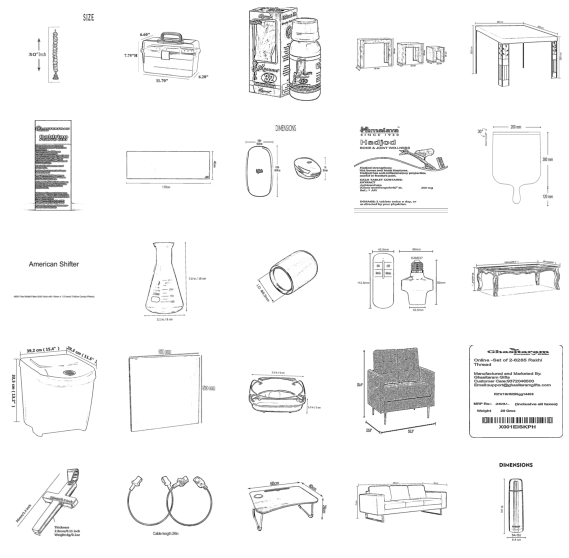

In [34]:
import matplotlib.pyplot as plt

# Get a batch of images from the data generator
batch_images = data_generator[64]  # Fetch the first batch

# Display the images
plt.figure(figsize=(10, 10))
for i in range(min(len(batch_images), 25)):  # Show up to 25 images
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(batch_images[i], cmap='gray')  # Use 'gray' cmap for grayscale images
    plt.axis('off')
plt.show()


## Splitting entity_value

In [35]:
train_cleaned.sample(5)

,image_link,group_id,entity_name,entity_value,image_filename
204825,https://m.media-amazon.com/images/I/511xqnh31Q...,889729,depth,30.0 centimetre,511xqnh31QL.jpg
49545,https://m.media-amazon.com/images/I/5152y2IcVP...,152057,item_weight,1 kilogram,5152y2IcVPL.jpg
157806,https://m.media-amazon.com/images/I/514Uj1LxsN...,276611,width,800.0 millimetre,514Uj1LxsNL.jpg
176384,https://m.media-amazon.com/images/I/61-ECzk5e3...,396159,width,7.9 inch,61-ECzk5e3L.jpg
258309,https://m.media-amazon.com/images/I/610h8PRfdH...,416664,height,21.6 inch,610h8PRfdHL.jpg


In [36]:
import pandas as pd

# Group by entity_name to see patterns
entity_group = train_cleaned.groupby('entity_name').size()
print(entity_group)


entity_name
depth                             42458
height                            39263
item_volume                        7655
item_weight                      102660
maximum_weight_recommendation      3191
voltage                            9144
wattage                            7455
width                             44080
dtype: int64


In [37]:
import pandas as pd

# Group by entity_name to see patterns
entity_group = train_cleaned.groupby('group_id').size()
print(entity_group)

group_id
101697      53
104874     132
106003     177
107694    1163
107915      25
          ... 
995200      39
995842     161
997176     108
997333       2
998545     175
Length: 750, dtype: int64


In [38]:
import pandas as pd
import re

# Define the function to extract value and unit
def extract_value_and_unit(text):
    pattern = r"(\d+\.?\d*)\s*([a-zA-Z]+)"
    matches = re.findall(pattern, text)
    if matches:
        value, unit = matches[0]
        return value, unit
    return None, None
    
# Apply the function and create new columns
train_cleaned[['value', 'unit']] = train_cleaned['entity_value'].apply(lambda x: pd.Series(extract_value_and_unit(x)))

# Print the resulting DataFrame
train_cleaned.sample(5)


/tmp/ipykernel_1552/196489792.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned[['value', 'unit']] = train_cleaned['entity_value'].apply(lambda x: pd.Series(extract_value_and_unit(x)))
/tmp/ipykernel_1552/196489792.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned[['value', 'unit']] = train_cleaned['entity_value'].apply(lambda x: pd.Series(extract_value_and_unit(x)))


,image_link,group_id,entity_name,entity_value,image_filename,value,unit
220897,https://m.media-amazon.com/images/I/51yuIkQZut...,242256,depth,150.0 centimetre,51yuIkQZutL.jpg,150.0,centimetre
233527,https://m.media-amazon.com/images/I/51YYfArlgj...,955322,height,20.5 centimetre,51YYfArlgjL.jpg,20.5,centimetre
237931,https://m.media-amazon.com/images/I/51qm+-lRuJ...,180726,height,30.0 millimetre,51qm+-lRuJL.jpg,30.0,millimetre
19828,https://m.media-amazon.com/images/I/51MOV7aOTK...,641642,voltage,12.0 volt,51MOV7aOTKL.jpg,12.0,volt
104132,https://m.media-amazon.com/images/I/81oJfhyHWh...,179080,voltage,48.0 volt,81oJfhyHWhL.jpg,48.0,volt


## OCR

In [39]:
'''import os
import re
from nltk.tokenize import word_tokenize
from PIL import Image
import easyocr
import pandas as pd

# Directory containing the images
image_dir = '../images'

# Get a list of all image file paths
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

# Initialize a dictionary to store extracted entities
extracted_entities = []

# Initialize easyocr Reader
reader = easyocr.Reader(['en'])

# Process images in chunks
chunk_size = 500  # Adjust based on your memory constraints
for i in range(0, len(image_files), chunk_size):
    chunk = image_files[i:i + chunk_size]
    for image_path in chunk:
        # Apply OCR to extract text from the image
        result = reader.readtext(image_path, detail=0)
        text = ' '.join(result)
        print(f"Image {image_path} Full Text: {text}")
        
        # Tokenize the text
        tokens = word_tokenize(text)
        processed_text = ' '.join(tokens)
        
        # Extract numbers and units based on the regex
        matches = re.findall(regex_pattern, processed_text)
        if matches:
            for match in matches:
                value, unit = match
                # Find the corresponding entity based on the unit
                entity = next((key for key, units in entity_unit_map.items() if unit in units), None)
                if entity:
                    extracted_entities.append({
                        'image_path': image_path,
                        'entity': entity,
                        'value': value,
                        'unit': unit
                    })
                    print(f"Image {image_path} Extracted: {entity} - {value} {unit}")
        else:
            print(f"Image {image_path}: No entities found")

# Convert results to a DataFrame
df = pd.DataFrame(extracted_entities)

# Save the results to a CSV file
df.to_csv('test_out.csv', index=False)

print("Processing complete. Results saved to test_out.csv.")'''

'import os\nimport re\nfrom nltk.tokenize import word_tokenize\nfrom PIL import Image\nimport easyocr\nimport pandas as pd\n\n# Directory containing the images\nimage_dir = \'../images\'\n\n# Get a list of all image file paths\nimage_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith((\'jpg\', \'jpeg\', \'png\'))]\n\n# Initialize a dictionary to store extracted entities\nextracted_entities = []\n\n# Initialize easyocr Reader\nreader = easyocr.Reader([\'en\'])\n\n# Process images in chunks\nchunk_size = 500  # Adjust based on your memory constraints\nfor i in range(0, len(image_files), chunk_size):\n    chunk = image_files[i:i + chunk_size]\n    for image_path in chunk:\n        # Apply OCR to extract text from the image\n        result = reader.readtext(image_path, detail=0)\n        text = \' \'.join(result)\n        print(f"Image {image_path} Full Text: {text}")\n        \n        # Tokenize the text\n        tokens = word_tokenize(text)\n        process

In [40]:
#extracted_entities

In [41]:
'''df = pd.DataFrame(extracted_entities)
df.to_csv('extract_data.csv', index=False)'''

"df = pd.DataFrame(extracted_entities)\ndf.to_csv('extract_data.csv', index=False)"

In [42]:
train_cleaned

,image_link,group_id,entity_name,entity_value,image_filename,value,unit
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram,61I9XdN6OFL.jpg,500.0,gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup,71gSRbyXmoL.jpg,1.0,cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram,61BZ4zrjZXL.jpg,0.709,gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram,612mrlqiI4L.jpg,0.709,gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram,617Tl40LOXL.jpg,1400,milligram
...,...,...,...,...,...,...,...
263854,https://m.media-amazon.com/images/I/612J1R1xHl...,558806,height,5.0 centimetre,612J1R1xHlL.jpg,5.0,centimetre
263855,https://m.media-amazon.com/images/I/61Blzh2+28...,470067,height,8.5 inch,61Blzh2+28L.jpg,8.5,inch
263856,https://m.media-amazon.com/images/I/51MsegDL9V...,204245,height,43.2 centimetre,51MsegDL9VL.jpg,43.2,centimetre
263857,https://m.media-amazon.com/images/I/510KhVw4VS...,752266,height,9.1 centimetre,510KhVw4VSL.jpg,9.1,centimetre


In [50]:
import numpy as np
import cv2
import os
from PIL import Image, ImageEnhance
import tensorflow as tf

class CustomImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, image_size, contrast_factor=1.1):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.contrast_factor = contrast_factor

    def preprocess_image(self, image):
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Denoise using Non-Local Means Denoising
        denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 5, 7, 21)
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for better contrast
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16, 16))
        enhanced_contrast = clahe.apply(denoised_image)
        
        # Adaptive thresholding for better binary conversion in uneven lighting
        binary_image = cv2.adaptiveThreshold(enhanced_contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                             cv2.THRESH_BINARY, 11, 2)
        
        # Optional: Apply morphological operations to clean up small noise
        kernel = np.ones((1, 1), np.uint8)
        morphed_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
        
        # Convert to PIL Image
        pil_image = Image.fromarray(morphed_image)
        
        # Enhance contrast using PIL for fine-tuning
        enhancer = ImageEnhance.Contrast(pil_image)
        enhanced_image = enhancer.enhance(self.contrast_factor)
        
        return np.array(enhanced_image)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        
        for path in batch_paths:
            try:
                image = cv2.imread(path)
                if image is None:
                    print(f"Warning: Unable to load image {path}")
                    continue
                image = cv2.resize(image, self.image_size)  # Resize image
                image = self.preprocess_image(image)  # Apply the preprocessing pipeline
                
                # Append to batch_images
                batch_images.append(image)
            except Exception as e:
                print(f"Error processing image {path}: {e}")
        
        batch_images = np.array(batch_images)
        return batch_images

# Example usage
image_dir = '../images_test'  # Directory containing input images
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.png'))]
batch_size = 64
image_size = (1024, 1024)  # Resize images to (width, height)

data_generator = CustomImageDataGenerator(image_paths, batch_size, image_size)

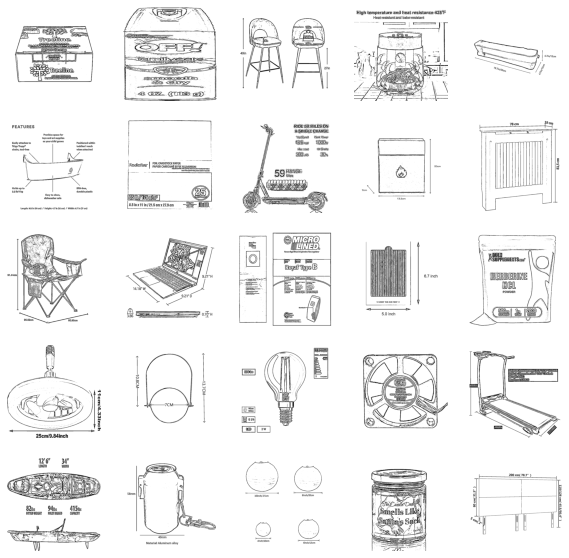

In [44]:
import matplotlib.pyplot as plt

# Get a batch of images from the data generator
batch_images = data_generator[64]  # Fetch the first batch

# Display the images
plt.figure(figsize=(10, 10))
for i in range(min(len(batch_images), 25)):  # Show up to 25 images
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(batch_images[i], cmap='gray')  # Use 'gray' cmap for grayscale images
    plt.axis('off')
plt.show()

In [51]:
total_images = len(image_paths)
total_batches = len(data_generator)

print(f"Total images: {total_images}")
print(f"Total batches: {total_batches}")


Total images: 90666
Total batches: 1417


In [ ]:
import os
import re
from nltk.tokenize import word_tokenize
from PIL import Image
import easyocr
import pandas as pd

# Directory containing the images
image_dir = '../images_test'

# Get a list of all image file paths
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

# Initialize a dictionary to store extracted entities
extracted_entities = []

# Initialize easyocr Reader
reader = easyocr.Reader(['en'])

# The entity-to-unit mapping dictionary
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
}

# Flatten the units and escape any special characters in the unit names
units = [re.escape(unit) for units in entity_unit_map.values() for unit in units]

# Join all the units into a single regex group
unit_pattern = '|'.join(units)

# Regex pattern to match a number followed by a unit
regex_pattern = rf'(\d+(?:\.\d+)?)\s*({unit_pattern})'

# Process images in chunks
chunk_size = 500  # Adjust based on your memory constraints
for i in range(0, len(image_files), chunk_size):
    chunk = image_files[i:i + chunk_size]
    for image_path in chunk:
        # Apply OCR to extract text from the image
        result = reader.readtext(image_path, detail=0)
        text = ' '.join(result)
        print(f"Image {image_path} Full Text: {text}")
        
        # Tokenize the text
        tokens = word_tokenize(text)
        processed_text = ' '.join(tokens)
        
        # Extract numbers and units based on the regex
        matches = re.findall(regex_pattern, processed_text)
        if matches:
            for match in matches:
                value, unit = match
                # Find the corresponding entity based on the unit
                entity = next((key for key, units in entity_unit_map.items() if unit in units), None)
                if entity:
                    extracted_entities.append({
                        'image_path': image_path,
                        'entity': entity,
                        'value': value,
                        'unit': unit
                    })
                    print(f"Image {image_path} Extracted: {entity} - {value} {unit}")
                else:
                   # Print this message only if no entities are found in the entire text
                   print(f"Image {image_path}: No entities found")

# Convert results to a DataFrame
df = pd.DataFrame(extracted_entities)

# Save the results to a CSV file
df.to_csv('test_out.csv', index=False)

print("Processing complete. Results saved to test_out.csv.")


Image ../images_test/110EibNyclL.jpg Full Text: 3rcn 4Gin - 7te 51 44mui eetcm
Image ../images_test/11gHj8dhhrL.jpg Full Text: Size Width Length One Size 10.50cm/4.13" 90cm/35.43"
Image ../images_test/11lshEUmCrL.jpg Full Text: Ustabcm
Image ../images_test/11TU2clswzL.jpg Full Text: Size Width Length One Size 42cm/16.54" 200cm/78.74"
Image ../images_test/21+i52HRW4L.jpg Full Text: 40 cm 30 cm 15 cm
Image ../images_test/21-LmSmehZL.jpg Full Text: 40 cm 30 cm 15 cm
Image ../images_test/213oP6n7jtL.jpg Full Text: 1TB=
Image ../images_test/213wY3gUsmL.jpg Full Text: J0,6cm 41.6cm 139,Scm
Image ../images_test/214CLs1oznL.jpg Full Text: 4.3in 10 cm
Image ../images_test/216rjgJHAeL.jpg Full Text: 
Image ../images_test/2174yonQBtL.jpg Full Text: Im1O;
Image ../images_test/218BCzgKxuL.jpg Full Text: Black Red Green 208-240V 16A 6OHz L2 GND Black White Green
Image ../images_test/21aD6ktvwxS.jpg Full Text: 5.8 in 14cm
Image ../images_test/21bfrFeArAL.jpg Full Text: 91 hampia JATCALGA4TE
Image ../